<a href="https://colab.research.google.com/github/AyushSinha2210/Machine_Learning/blob/main/TimeSeriesForecastingUsing_SVR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [715]:
import sys
sys.path.append('../../')

In [716]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

In [717]:
def load_data(file_path):
  df=pd.read_csv(file_path)
  return df

In [718]:
a='/content/Tesla_stock_data.csv'
energy=load_data(a)

In [719]:
energy.head()

,Date,Close,High,Low,Open,Volume
0,2010-06-29,1.59,1.67,1.17,1.27,281494500
1,2010-06-30,1.59,2.03,1.55,1.72,257806500
2,2010-07-01,1.46,1.73,1.35,1.67,123282000
3,2010-07-02,1.28,1.54,1.25,1.53,77097000
4,2010-07-06,1.07,1.33,1.06,1.33,103003500


In [720]:
energy.describe()

,Close,High,Low,Open,Volume
count,"3,798.00","3,798.00","3,798.00","3,798.00","3,798.00"
mean,90.56,92.61,88.43,90.59,"97,099,811.08"
std,115.25,117.95,112.48,115.35,"76,609,832.97"
min,1.05,1.11,1.00,1.08,"1,777,500.00"
25%,12.58,12.81,12.29,12.57,"50,555,850.00"
50%,19.05,19.43,18.70,19.00,"83,377,800.00"
75%,194.90,199.28,190.56,195.30,"122,515,275.00"
max,479.86,488.54,457.51,475.90,"914,082,000.00"


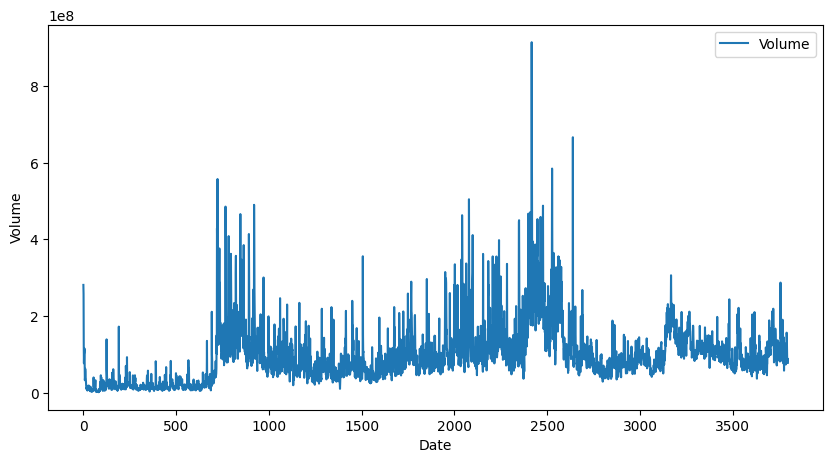

In [721]:
energy.plot(y='Volume',subplots=True,figsize=(10,5),fontsize=10)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Volume',fontsize=10)
plt.show()

**Now Building A SVR Model**

In [722]:
train_start_dt='2010-10-01 00:00:00'
test_start_dt='2017-02-20 00:00:00'

In [723]:
energy['Date'] = pd.to_datetime(energy['Date'])
energy = energy.set_index('Date')

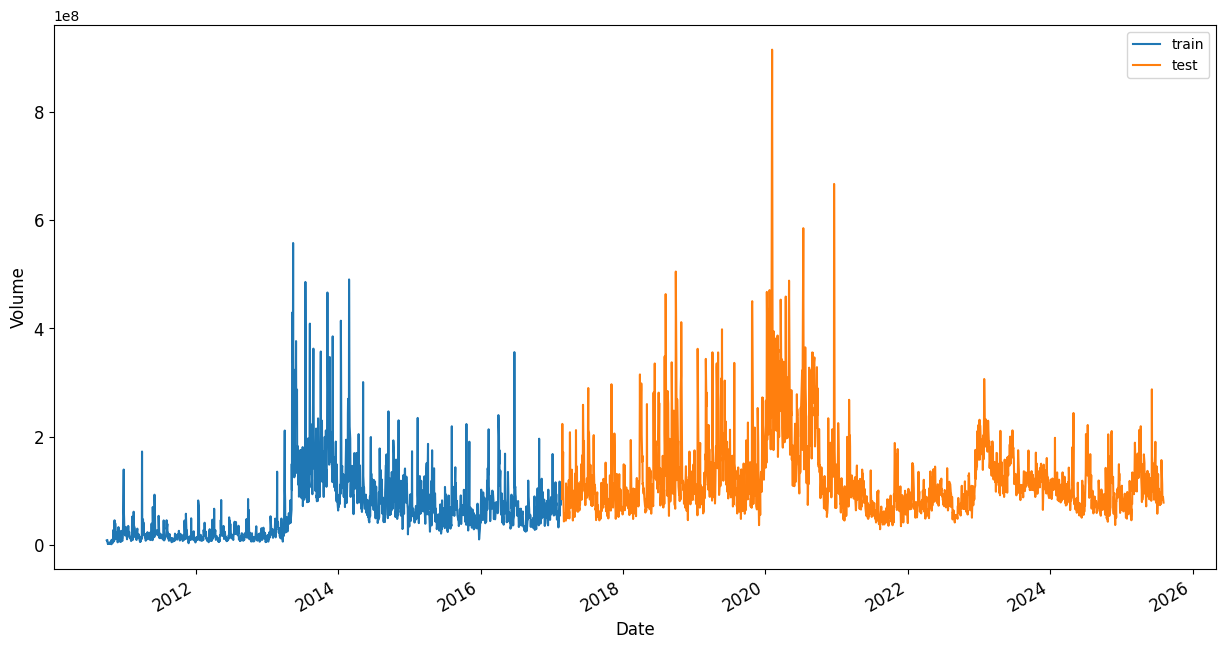

In [724]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['Volume']].rename(columns={'Volume':'train'}) \
    .join(energy[test_start_dt:][['Volume']].rename(columns={'Volume':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.show()

In [725]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['Volume']]
test = energy.copy()[energy.index >= test_start_dt][['Volume']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1607, 1)
Test data shape:  (2125, 1)


In [726]:
scaler=MinMaxScaler()
train['Volume']=scaler.fit_transform(train)
test['Volume']=scaler.transform(test)

In [727]:
train_data=train.values
test_data=test.values

In [728]:
timesteps=5

In [729]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]

In [730]:
train_data_timesteps.shape
test_data_timesteps.shape

(2121, 5)

In [731]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1603, 4) (1603, 1)
(2121, 4) (2121, 1)


**Implement SVR**

In [732]:
model=SVR(kernel='rbf',gamma=0.9,C=0.8,epsilon=0.05)

In [733]:
model.fit(x_train,y_train[:,0])

SVR(C=0.8, epsilon=0.05, gamma=0.9)

In [734]:
y_train_predict=model.predict(x_train).reshape(-1,1)
y_test_predict=model.predict(x_test).reshape(-1,1)
print(y_train_predict.shape,y_test_predict.shape)

(1603, 1) (2121, 1)


In [735]:
# Scaling the predictions
y_train_pred = scaler.inverse_transform(y_train_predict)
y_test_pred = scaler.inverse_transform(y_test_predict)

print(len(y_train_pred), len(y_test_pred))

1603 2121


In [736]:
# Scaling the original values
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

print(len(y_train), len(y_test))

1603 2121


In [737]:
train_timestamps = energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = energy[test_start_dt:].index[timesteps-1:]

print(len(train_timestamps), len(test_timestamps))

1603 2121


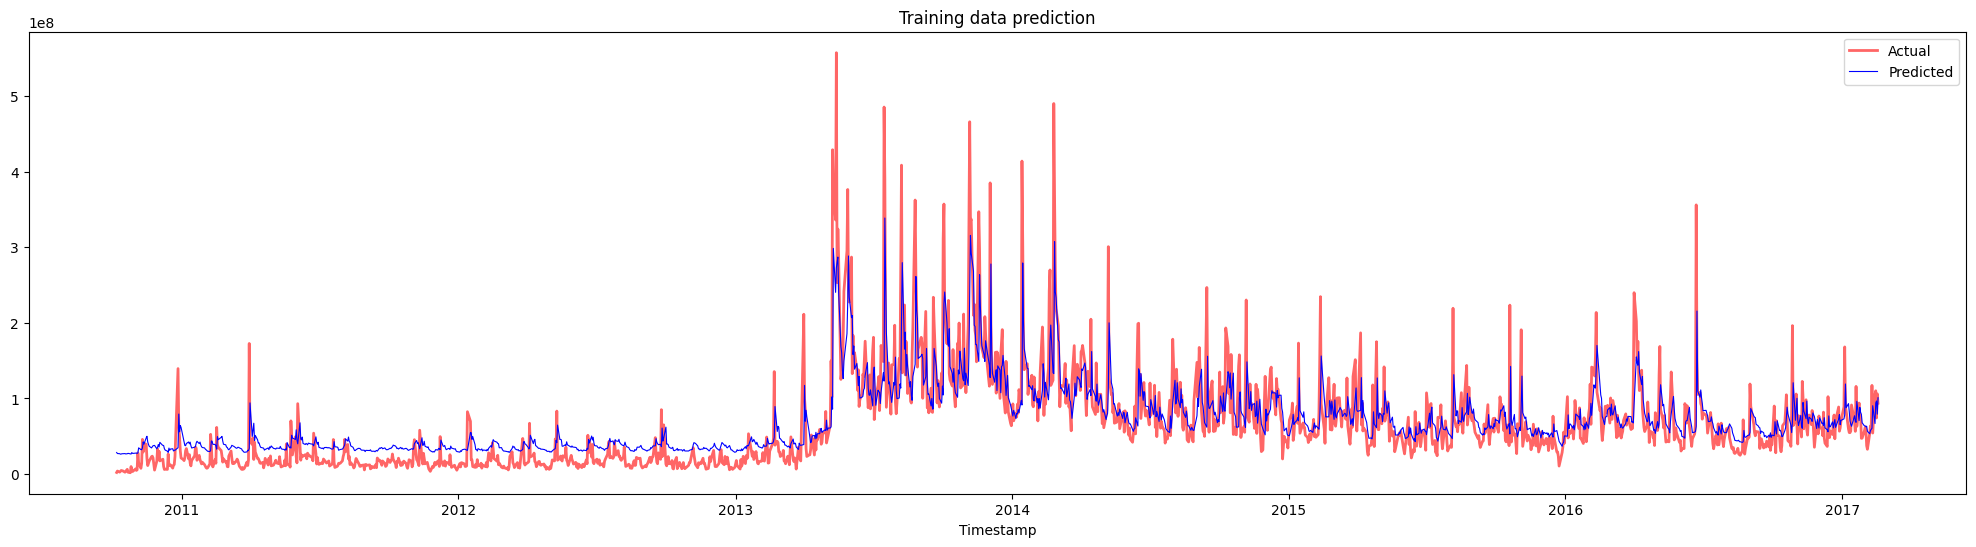

In [738]:
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

In [739]:
print('MAPE for training data: ', mape(y_train_pred, y_train)*100, '%')

MAPE for training data:  41.68198463193313 %


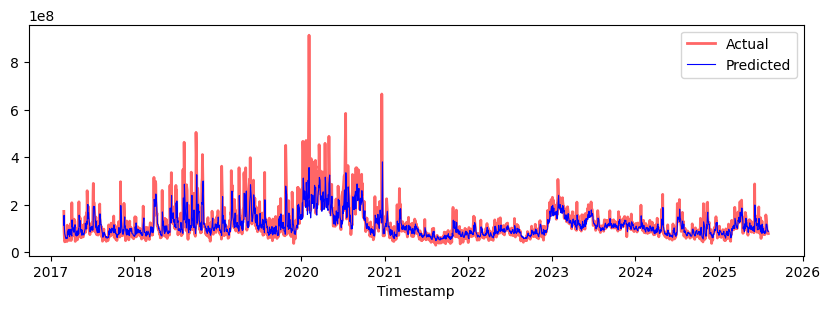

In [740]:
plt.figure(figsize=(10,3))
plt.plot(test_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

In [741]:
print('MAPE for testing data: ', mape(y_test_pred, y_test)*100, '%')

MAPE for testing data:  25.203791394179937 %


In [742]:
# Extracting load values as numpy array
data = energy.copy()[['Volume']].values

# Scaling
data = scaler.transform(data)

# Transforming to 2D tensor as per model input requirement
data_timesteps=np.array([[j for j in data[i:i+timesteps]] for i in range(0,len(data)-timesteps+1)])[:,:,0]
print("Tensor shape: ", data_timesteps.shape)

# Selecting inputs and outputs from data
X, Y = data_timesteps[:,:timesteps-1],data_timesteps[:,[timesteps-1]]
print("X shape: ", X.shape,"\nY shape: ", Y.shape)

Tensor shape:  (3794, 5)
X shape:  (3794, 4) 
Y shape:  (3794, 1)


In [743]:
# Make model predictions
Y_pred = model.predict(X).reshape(-1,1)

# Inverse scale and reshape
Y_pred = scaler.inverse_transform(Y_pred)
Y = scaler.inverse_transform(Y)

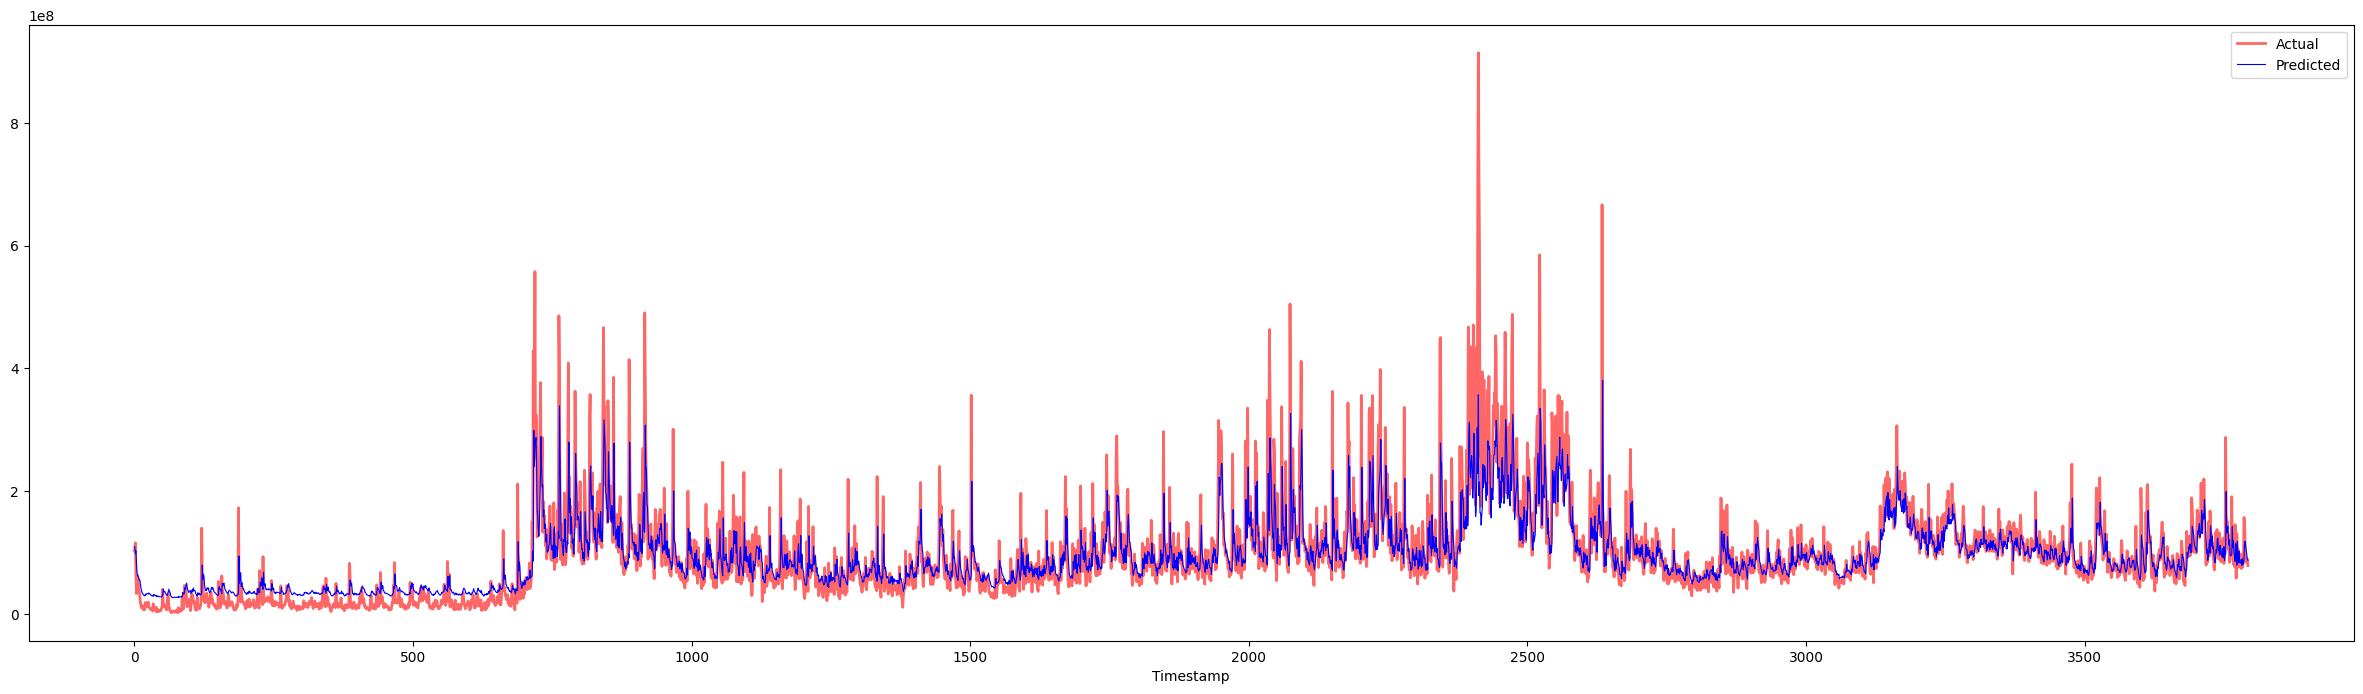

In [744]:
plt.figure(figsize=(30,8))
plt.plot(Y, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(Y_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

In [745]:
print('MAPE: ', mape(Y_pred, Y)*100, '%')

MAPE:  32.794379677305265 %
